<a href="https://colab.research.google.com/github/Bajbalemonika-05/DL-project/blob/main/DL_Project(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [4]:
from google.colab import drive
drive.mount('/content/drive',timeout_ms=300000)

Mounted at /content/drive


In [6]:
#Fetch Images count from Folders
dirs = os.listdir('/content/drive/MyDrive/Flask_project/image')
for dir in dirs:
    # Add a '/' between the base path and the subdirectory name
    files = list(os.listdir('/content/drive/MyDrive/Flask_project/image/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')

Real Images Folder has 5050 Images
AI-Generated Images Folder has 4679 Images


All the images stored in folder as a file, so we have to load them as numpy array.

In [7]:
#Load Images into Arrays as Dataset
base_dir = '/content/drive/MyDrive/Flask_project/image'
# Update base_dir to the full path
img_size = 180
batch = 32

#Training
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))
#Testing
val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 9729 files belonging to 2 classes.
Using 7784 files for training.
Found 9729 files belonging to 2 classes.
Using 1945 files for validation.


In [8]:
#check data names
#For training dataset
real_face= train_ds.class_names
real_face

['AI-Generated Images', 'Real Images']

In [9]:
#check data names
#For testing dataset
real_face2 = val_ds.class_names
real_face2

['AI-Generated Images', 'Real Images']

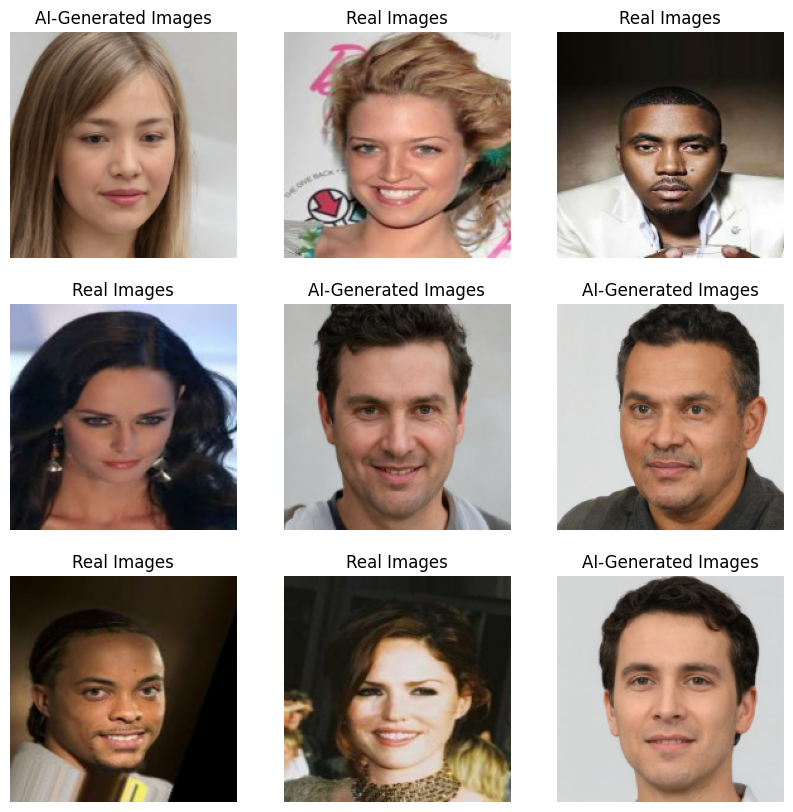

In [10]:
#Take random 9 flowers from Training dataset
import matplotlib.pyplot as plt
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(real_face[labels[i]])
        plt.axis('off')

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [13]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE) # dont need to shuffle for testing dataset

**<h2>Data Augmentation**

In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

**<h2>Model deployment**

In [17]:
#Model Creation
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(128, 3, padding='same', activation='relu'),
    #we are not providing i/p shape here as we have already update this as image_size in train_ds
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5,activation='softmax')
])

In [ ]:
model.summary()

In [20]:
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy
model.compile(optimizer='sgd', # Changed optimizer
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

model.fit(train_ds, epochs=5, validation_data=val_ds) # Increased epochs

Epoch 1/5
244/244 [==============================] - 169s 689ms/step - loss: 0.1785 - accuracy: 0.9331 - val_loss: 0.0814 - val_accuracy: 0.9717
Epoch 2/5
244/244 [==============================] - 169s 692ms/step - loss: 0.1124 - accuracy: 0.9580 - val_loss: 0.0700 - val_accuracy: 0.9774
Epoch 3/5
244/244 [==============================] - 169s 693ms/step - loss: 0.0898 - accuracy: 0.9648 - val_loss: 0.0297 - val_accuracy: 0.9913
Epoch 4/5
244/244 [==============================] - 170s 696ms/step - loss: 0.0637 - accuracy: 0.9765 - val_loss: 0.0209 - val_accuracy: 0.9954
Epoch 5/5
244/244 [==============================] - 169s 693ms/step - loss: 0.0484 - accuracy: 0.9830 - val_loss: 0.0173 - val_accuracy: 0.9954


In [ ]:
# from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy
# model.compile(optimizer='adam',
#               loss=SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model.fit(train_ds, epochs=10, validation_data=val_ds)

In [21]:
input_image = tf.keras.utils.load_img('/content/drive/MyDrive/Flask_project/Sample/ai_face_sample/000032.jpg', target_size=(180,180))
input_image_array = tf.keras.utils.img_to_array(input_image)
input_image_exp_dim = tf.expand_dims(input_image_array,0)

predictions = model.predict(input_image_exp_dim)
result = tf.nn.softmax(predictions[0])
real_face[np.argmax(result)]

1/1 [==============================] - 0s 113ms/step


'AI-Generated Images'

In [23]:
#For all the images:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + real_face[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [24]:
classify_images('/content/drive/MyDrive/Flask_project/Sample/ai_face_sample/000015.jpg')

1/1 [==============================] - 0s 32ms/step


'The Image belongs to AI-Generated Images with a score of 40.45568406581879'

In [27]:
model.evaluate(train_ds)

244/244 [==============================] - 37s 153ms/step - loss: 0.0154 - accuracy: 0.9958


[0.01537267491221428, 0.9957605600357056]